## Spam Ham Classifier

### Importing the liberaries

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

### Importing the datasset

In [ ]:
df = pd.read_csv('spam.csv', encoding=('ISO-8859-1'))
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [ ]:
# Get only necessary columns for Processing and drop unnecessary columns
dataset = df[['v1', 'v2']]
dataset.rename(columns={'v1': 'target', 'v2': 'sentence'}, inplace=True)
dataset

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,target,sentence
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [ ]:
# Get X and y
X = dataset['sentence'].to_numpy()
y = dataset['target'].to_numpy()

In [ ]:
encoder = LabelEncoder()
y = encoder.fit_transform(y) 
encoder.classes_

array(['ham', 'spam'], dtype=object)

## Creating train, validation and test dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.15)
len(X_train), len(X_test), len(y_train), len(y_test)

(4736, 836, 4736, 836)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1)
len(X_train), len(X_val), len(y_train), len(y_val)

(4262, 474, 4262, 474)

## Exploring the data

In [ ]:
# Let's visualize some random training examples
for i in range(20):
    print(f"""Sentence Number: {i}
    Sentence: {X_train[i]}
    Target: {y_train[i]}""")

Sentence Number: 0
    Sentence: *deep sigh* ... I miss you :-( ... I am really surprised you haven't gone to the net cafe yet to get to me ... Don't you miss me?
    Target: 0
Sentence Number: 1
    Sentence: Dear,Me at cherthala.in case u r coming cochin pls call bfore u start.i shall also reach accordingly.or tell me which day u r coming.tmorow i am engaged ans its holiday.
    Target: 0
Sentence Number: 2
    Sentence: Now only i reached home. . . I am very tired now. . I will come tomorro
    Target: 0
Sentence Number: 3
    Sentence: SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info
    Target: 1
Sentence Number: 4
    Sentence: There'll be a minor shindig at my place later tonight, you interested?
    Target: 0
Sentence Number: 5
    Sentence: Thanx. Yup we coming back on sun. Finish dinner going back 2 hotel now. Time flies, we're tog 4 exactly a mth today. Hope we'll haf many more mths to co

In [ ]:
# Check the number of counts of spam and ham
pd.Series(y_train).value_counts()

0    3697
1     565
dtype: int64

## Converting text into numbers

In [ ]:
# Find the average number of words in training Data
round(sum([len(i.split()) for i in X_train]) / len(X_train))

15

In [ ]:
# Using TextVectorization layer of keras API for converting text into nunbers
max_vocab_length = 10000
max_length = 15

text_vectorizer = layers.TextVectorization(max_tokens=max_vocab_length, 
                                           output_mode='int', 
                                           output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence} \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
Kit Strip - you have been billed 150p. Netcollex Ltd. PO Box 1013 IG11 OJA 

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[5894, 4376,    4,   18,  100, 3403,  637, 2060,  664,  342,  310,
        8053, 6096, 5318,    0]])>

In [ ]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}") 
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 8227
Top 5 most common words: ['', '[UNK]', 'i', 'to', 'you']
Bottom 5 least common words: ['02', '0125698789', '01223585334', '01223585236', '0089my']


### Creating an Embedding using an Embedding Layer

In [ ]:
embedding = layers.Embedding(input_dim=max_vocab_length, 
                             output_dim=128, 
                             input_length=max_length)
embedding

In [ ]:
# # Get a random sentence from training set
random_sentence = random.choice(X_train)
print(f"Original text:\n{random_sentence}\n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
85233 FREE>Ringtone!Reply REAL

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.04388005, -0.04186267,  0.02683913, ...,  0.04043469,
          0.02209893, -0.00077416],
        [-0.0299746 ,  0.04341941,  0.00361886, ..., -0.0392972 ,
         -0.04846728,  0.04010352],
        [-0.00997481,  0.00248851, -0.00907714, ...,  0.04844148,
          0.01461795, -0.01491167],
        ...,
        [-0.01897813, -0.01297478,  0.02599012, ..., -0.0315019 ,
          0.02169282, -0.01902304],
        [-0.01897813, -0.01297478,  0.02599012, ..., -0.0315019 ,
          0.02169282, -0.01902304],
        [-0.01897813, -0.01297478,  0.02599012, ..., -0.0315019 ,
          0.02169282, -0.01902304]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.04388005, -0.04186267,  0.02683913, -0.00716706,  0.00783572,
       -0.0030501 ,  0.03451211, -0.02109083, -0.02914596,  0.04826543,
        0.03091084, -0.04759959, -0.02180872,  0.04147309,  0.0401338 ,
        0.03125748,  0.04928492, -0.03460912,  0.03812032,  0.03992632,
       -0.03095394,  0.04906521,  0.00493925,  0.04854352,  0.04287951,
        0.00699922,  0.01170677,  0.02448717,  0.04885019, -0.04362352,
       -0.02459912, -0.03935804, -0.04397475,  0.00503606,  0.03612936,
       -0.01364027, -0.0455587 ,  0.03307037, -0.04934882, -0.04716563,
       -0.0407251 , -0.03950778,  0.0114034 ,  0.01162971, -0.00256882,
        0.0257658 ,  0.04668942,  0.04329658, -0.01881421,  0.04120215,
        0.04180521,  0.00027103, -0.02395122, -0.02946438,  0.04604589,
        0.02890344,  0.03069073,  0.02247642,  0.013228  , -0.02152485,
       -0.04923732, -0.04632813, -0.00960699,  0.04898218, -0.04764621,
        0.015781

In [ ]:
# Creating get_textvectorization_embedding function
def get_textvectorization_embedding(sentence):
    return embedding(text_vectorizer(sentence))

In [ ]:
# Testing our function 
sample_sentence = get_textvectorization_embedding('Cos i want it to be your thing')
(sample_sentence == sample_embed).numpy().mean()

0.4666666666666667

## Building an LSTM

In [ ]:
# Create a lstm model
inputs = layers.Input(shape=(1, ), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(256, return_sequences=True)(x)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs, name='Model_LSTM')

In [ ]:
model.summary()

Model: "Model_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization_1 (TextVe (None, 15)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 15, 128)           1280000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 15, 256)           394240    
_________________________________________________________________
lstm_7 (LSTM)                (None, 15, 128)           197120    
_________________________________________________________________
lstm_8 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6

## Compiling and Fitting the model

In [ ]:
# Compile model
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=3, 
                    validation_data=(X_val, y_val), 
                    callbacks=[tf.keras.callbacks.ModelCheckpoint('model_checkpoint', name=model.name)])

Epoch 1/3
134/134 [==============================] - 37s 239ms/step - loss: 0.0118 - accuracy: 0.9974 - val_loss: 0.1299 - val_accuracy: 0.9662


INFO:tensorflow:Assets written to: model_checkpoint/assets


INFO:tensorflow:Assets written to: model_checkpoint/assets


Epoch 2/3
134/134 [==============================] - 18s 132ms/step - loss: 0.0043 - accuracy: 0.9991 - val_loss: 0.0893 - val_accuracy: 0.9747


INFO:tensorflow:Assets written to: model_checkpoint/assets


INFO:tensorflow:Assets written to: model_checkpoint/assets


Epoch 3/3
134/134 [==============================] - 18s 131ms/step - loss: 3.3199e-04 - accuracy: 1.0000 - val_loss: 0.1248 - val_accuracy: 0.9789


INFO:tensorflow:Assets written to: model_checkpoint/assets


INFO:tensorflow:Assets written to: model_checkpoint/assets


## Evaluating the model

In [ ]:
model.evaluate(X_test, y_test)

27/27 [==============================] - 1s 34ms/step - loss: 0.1248 - accuracy: 0.9773


[0.12479067593812943, 0.9772727489471436]

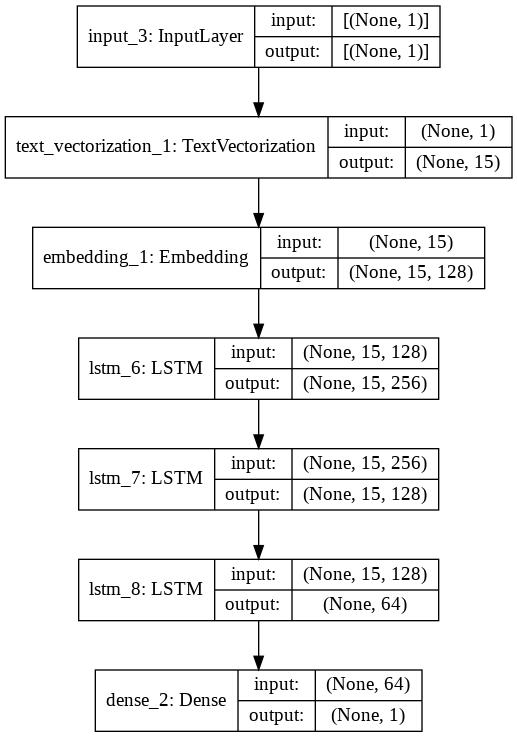

In [ ]:
# Plot the model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [ ]:
# Make predictions 
y_pred_probs = model.predict(X_test)
y_pred_probs[:10], y_pred_probs.shape

(array([[9.0768814e-01],
        [1.3994575e-03],
        [1.2347779e-01],
        [5.2835683e-05],
        [9.9994218e-01],
        [1.8768165e-05],
        [2.9258859e-05],
        [1.6349073e-05],
        [1.5666412e-05],
        [1.8863269e-05]], dtype=float32), (836, 1))

In [ ]:
# Getting the predictions out of probabilities
y_preds = tf.squeeze(tf.round(y_pred_probs)).numpy()
y_preds[:10]

array([1., 0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
y_preds.shape, y_test.shape

((836,), (836,))

In [ ]:
# Make Confusion matrix
cm = confusion_matrix(y_test, y_preds)
cm

array([[719,   9],
       [ 10,  98]])

In [ ]:
pd.Series(y_test).value_counts()

0    728
1    108
dtype: int64

## Get the most wrong predictions

In [ ]:
# Create a dataframe according to their predictions
df_test_preds = pd.DataFrame({'sentence': X_test, 
                              'target': y_test, 
                              'pred':y_preds, 
                              'pred_probs': tf.squeeze(y_pred_probs, axis=0)})
df_test_preds

,sentence,target,pred,pred_probs
0,"Funny fact Nobody teaches volcanoes 2 erupt, t...",0,1.0,0.907688
1,I sent my scores to sophas and i had to do sec...,0,0.0,0.001399
2,We know someone who you know that fancies you....,1,0.0,0.123478
3,Only if you promise your getting out as SOON a...,0,0.0,0.000053
4,Congratulations ur awarded either å£500 of CD ...,1,1.0,0.999942
...,...,...,...,...
831,IÛ÷m parked next to a MINI!!!! When are you c...,0,0.0,0.000053
832,"Sorry my roommates took forever, it ok if I co...",0,0.0,0.000017
833,"Daddy, shu shu is looking 4 u... U wan me 2 te...",0,0.0,0.000025
834,Smith waste da.i wanna gayle.,0,0.0,0.000023


In [ ]:
df_test_preds['target'][1] == df_test_preds['pred'][1]

True

In [ ]:
# Get the most wrong sentences
most_wrong = df_test_preds[df_test_preds['target'] !=
                           df_test_preds['pred']].sort_values('pred_probs',
                                                              ascending=False)
most_wrong.head()

,sentence,target,pred,pred_probs
268,"Urgh, coach hot, smells of chip fat! Thanks ag...",0,1.0,0.999788
707,\HI BABE UAWAKE?FEELLIKW SHIT.JUSTFOUND OUT VI...,0,1.0,0.996756
814,"Whenevr ur sad, Whenevr ur gray, Remembr im he...",0,1.0,0.985806
161,Waqt se pehle or naseeb se zyada kisi ko kuch ...,0,1.0,0.985650
573,Alright i have a new goal now,0,1.0,0.975939


In [ ]:
classes = encoder.classes_
classes

array(['ham', 'spam'], dtype=object)

In [ ]:
# Check the false positives 
for row in most_wrong[:20].itertuples():
    _, sentence, target, pred, pred_prob = row
    print(f"Target: {target}, Pred: {pred}, Prob: {pred_prob}")
    print(f"Text: ")
    print(sentence)
    print('\n' + '-'*60+ '\n')

Target: 0, Pred: 1.0, Prob: 0.9997881650924683
Text: 
Urgh, coach hot, smells of chip fat! Thanks again, especially for the duvet (not a predictive text word).

------------------------------------------------------------

Target: 0, Pred: 1.0, Prob: 0.9967561960220337
Text: 
\HI BABE UAWAKE?FEELLIKW SHIT.JUSTFOUND OUT VIA ALETTER THATMUM GOTMARRIED 4thNOV.BEHIND OURBACKS åÐ FUCKINNICE!SELFISH

------------------------------------------------------------

Target: 0, Pred: 1.0, Prob: 0.9858063459396362
Text: 
Whenevr ur sad, Whenevr ur gray, Remembr im here 2 listn 2 watevr u wanna say, Jus walk wid me a little while,&amp; I promise I'll bring back ur smile.:-)

------------------------------------------------------------

Target: 0, Pred: 1.0, Prob: 0.985649824142456
Text: 
Waqt se pehle or naseeb se zyada kisi ko kuch nahi milta,Zindgi wo nahi he jo hum sochte hai Zindgi wo hai jo ham jeetey hai..........

------------------------------------------------------------

Target: 0, Pred: 

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/Models/Spam-Ham')